# Построение и анализ модели
________________________________________________________________________________________

В этом ноутбуке по результатам EDA (`EDA_abalone.ipynb`) производится обучение моделей машинного обучения для решения задачи регрессии по предсказанию возраста морского ушка.

В ноутбуке приведено:
- построение базовых и дополнительных моделей на полном наборе данных;
- подбор гиперпараметров с целью повысить качество базовых моделей и дополнительных моделей на полном наборе данных;
- построен и проведен анализ в Explainer Dashboard;
- выбор лучшей модели для решения задачи.

**Импорт библиотек**

In [1]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

### Загрузка данных

In [2]:
df = pd.read_csv('processed_abalon.csv')

In [3]:
df.head()

,Unnamed: 0,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,3,M,0.440,0.365,0.125,0.7985,0.2155,0.1140,0.155,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Дропним признак - `Unnamed: 0`.

In [4]:
df.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4175 entries, 0 to 4174
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4175 non-null   object 
 1   Length          4175 non-null   float64
 2   Diameter        4175 non-null   float64
 3   Height          4175 non-null   float64
 4   Whole weight    4175 non-null   float64
 5   Shucked weight  4175 non-null   float64
 6   Viscera weight  4175 non-null   float64
 7   Shell weight    4175 non-null   float64
 8   Rings           4175 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.7+ KB


Пропусков нет.

Посмотрим, сколько у нас дубликатов.

In [6]:
df.duplicated().sum()

0

Дубликатов нет, все объекты уникальны.

### Анализ целевой переменной

Посмотрим распределение `Rings`

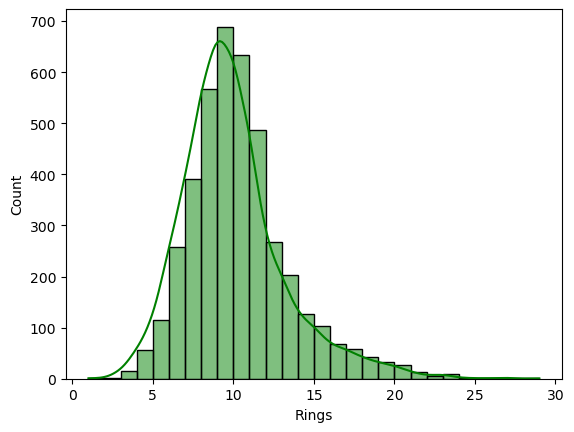

In [7]:
sns.histplot(df['Rings'],bins=28, kde=True, color='green')
plt.show();

In [8]:
df['Rings'].value_counts()

Rings
9     689
10    634
8     567
11    487
7     391
12    267
6     258
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
27      2
24      2
1       1
26      1
29      1
2       1
25      1
Name: count, dtype: int64

Видим, что некоторых объектов очень мало. Модели будет тяжело из предсказывать.

Сначала построим модель только на числовых признаках.

In [9]:
numeric_data = df.select_dtypes('number')

In [10]:
numeric_data.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.7985,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Обучение и построение моделей

Создадим матрицу X, содержащую все признаки, и не содержащую целевую переменную `Rings`. Также создадим вектор y, содержащий целевую переменную `Rings`.

In [11]:
X = numeric_data.drop(columns=['Rings'])
y = numeric_data['Rings']

#### Вспомогательные функции

In [12]:
def preprocess_data(X, y, scaler, size_test = 0.2):    
    '''
    Функция разделяет набор данных на тренировочные и тестовые наборы данных.
    Также приводит нормализацию признаков при помощи преобразователей из модуля sklearn.preprocessing.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size_test, random_state = 10)
    
    ss = scaler
    ss.fit(X_train)
    Xtrain = pd.DataFrame(ss.transform(X_train), columns = X_train.columns)
    Xtest = pd.DataFrame(ss.transform(X_test), columns = X_train.columns)

    return X_train, X_test, y_train, y_test

In [13]:
def lern_models(ml_model, X_train, X_test, y_train, y_test):
    '''
    Функция, представляющая отчет о качестве обученной модели.
    Возвращает словарь:
    - обученную модель;
    - вектор предсказаний (predictions);
    - метрики обучения (MAE, R2).
    '''
    model = ml_model
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    MAE_train = mean_absolute_error(model.predict(X_train), y_train)
    MAE_test = mean_absolute_error(y_test, pred)
    R2_test = r2_score(y_test, pred)

    cv = cross_validate(model, X_train, y_train, scoring=['neg_mean_absolute_error', 'r2'], cv=4, n_jobs=-1)
    MAE_val = -1*cv['test_neg_mean_absolute_error'].mean()
    R2_val = cv['test_r2'].mean()
    
    dict_lern_model = {'model': model,
                       'predictions': pred,
                       'MAE_train': MAE_train,
                       'MAE_test': MAE_test,
                       'R2_test': R2_test,
                       'MAE_val': MAE_val,
                       'R2_val': R2_val
                      }
                       
    return dict_lern_model

In [14]:
def model_scatterplot(y_test, pred, name_model, train_mae_metr, test_mae_metr, test_r2_metr, mae_cv, r2_cv):
    '''
    Функция даёт графическое визуализацию об обученной модели и метрики обучения
    '''
    plt.figure(figsize=(6,6))
    # Строим точки, соответствущие парам настоящее значение - прогноз
    sns.scatterplot(x=y_test, y=pred)
    # Добавление линии идентичности (идеальное предсказание)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  
    plt.xlabel('Настоящее значение', fontsize=15)
    plt.ylabel('Предсказанное значение', fontsize=15)
    plt.title(f'Диаграмма рассеяния между настоящими значениями и прогнозами. Модель {name_model}', fontsize=20)

    plt.show();
    print(f'MAE_train: {train_mae_metr.round(3)}')
    print(f'MAE_test: {test_mae_metr.round(3)}')
    print(f'R2_test: {test_r2_metr.round(3)}')
    print(f'MAE (4 folds): {mae_cv.round(3)}')
    print(f'R2 (4 folds): {r2_cv.round(3)}')

In [15]:
X_train, X_test, y_train, y_test = preprocess_data(X, y, scaler = MinMaxScaler(), size_test = 0.2)

#### Построение моделей с параметрами по умолчанию

В качестве базовых исследуемых моделей возьмем BayesianRidge и KNeighborsRegressor.

In [16]:
basic_model = [BayesianRidge(), KNeighborsRegressor()]

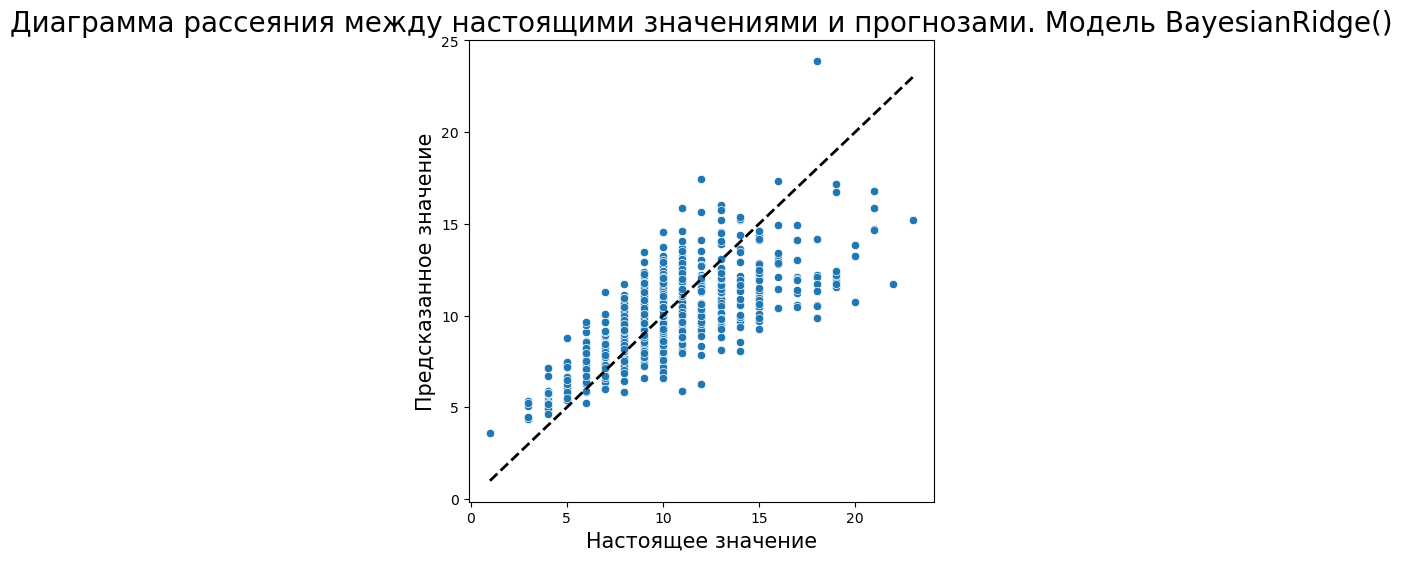

MAE_train: 1.664
MAE_test: 1.615
R2_test: 0.523
MAE (4 folds): 1.671
R2 (4 folds): 0.474


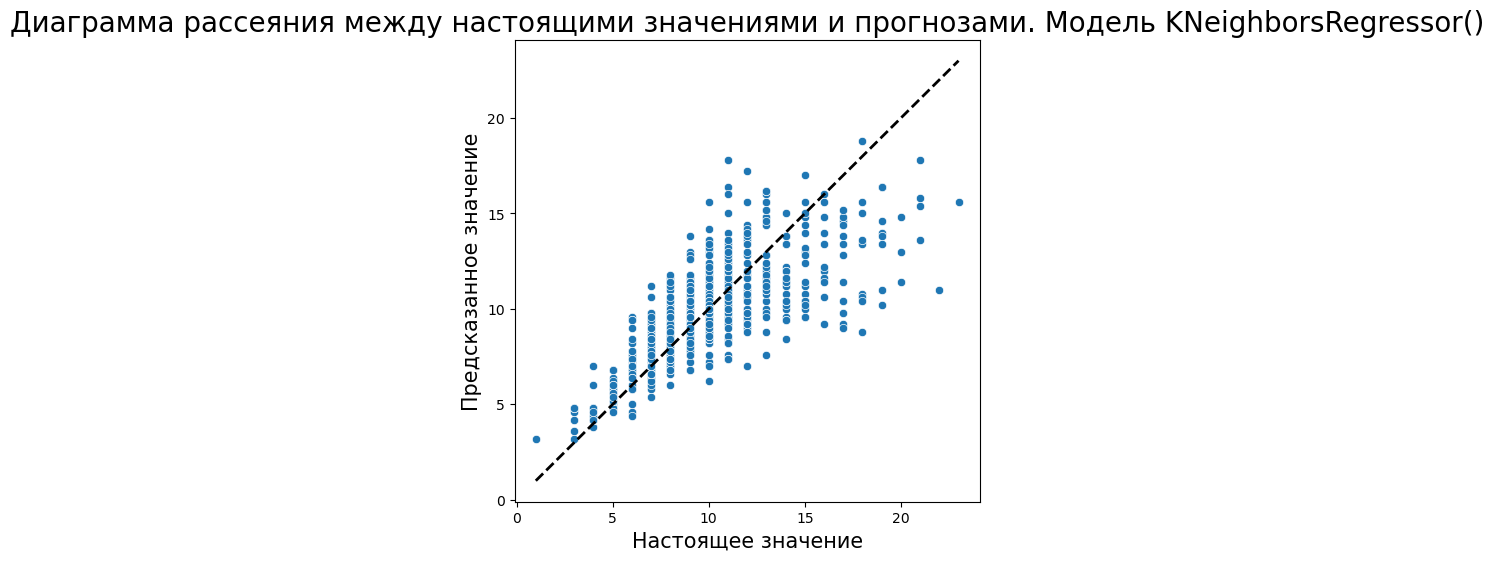

MAE_train: 1.332
MAE_test: 1.512
R2_test: 0.539
MAE (4 folds): 1.631
R2 (4 folds): 0.486


In [17]:
for model in basic_model:
    dict_model = lern_models(ml_model=model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
    model_scatterplot(y_test=y_test,
                      pred=dict_model['predictions'],
                      name_model=dict_model['model'],
                      train_mae_metr=dict_model['MAE_train'],
                      test_mae_metr=dict_model['MAE_test'],
                      test_r2_metr=dict_model['R2_test'],
                      mae_cv=dict_model['MAE_val'],
                      r2_cv=dict_model['R2_val']
                     )
                      

**Комментарий по результатам**

1. Обучили две модели (`BayesianRidge` и `KNeighborsRegressor`) на полном наборе данных.
2. Средняя абсолютная ошибка (mae) для `BayesianRidge` и `KNeighborsRegressor` составила *1.671* и *1.631* соответсвенно.
3. Коэфициент детерминации (r2) показал, что модель `BayesianRidge` работает лучше, чем `KNeighborsRegressor`.

Посмотрим на линейные модели LinearRegression и Ridge, а также на RandomForestRegressor.

In [18]:
additional_model = [LinearRegression(), Ridge(), RandomForestRegressor(random_state=123)]

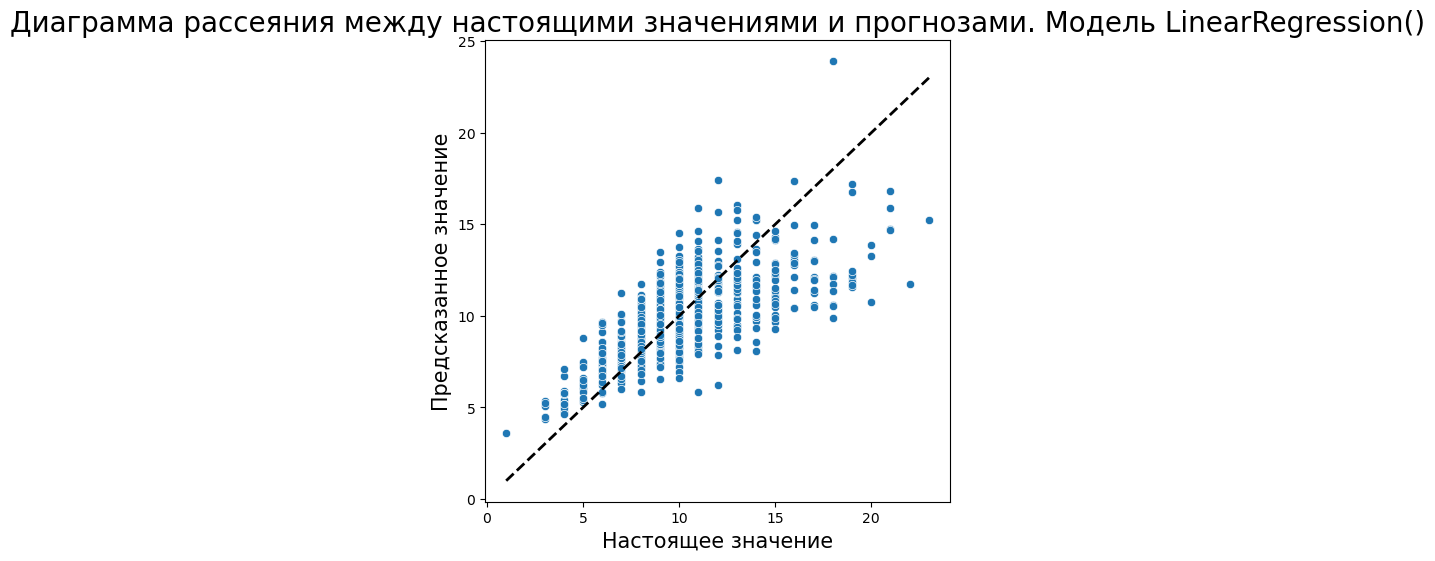

MAE_train: 1.664
MAE_test: 1.615
R2_test: 0.523
MAE (4 folds): 1.671
R2 (4 folds): 0.472


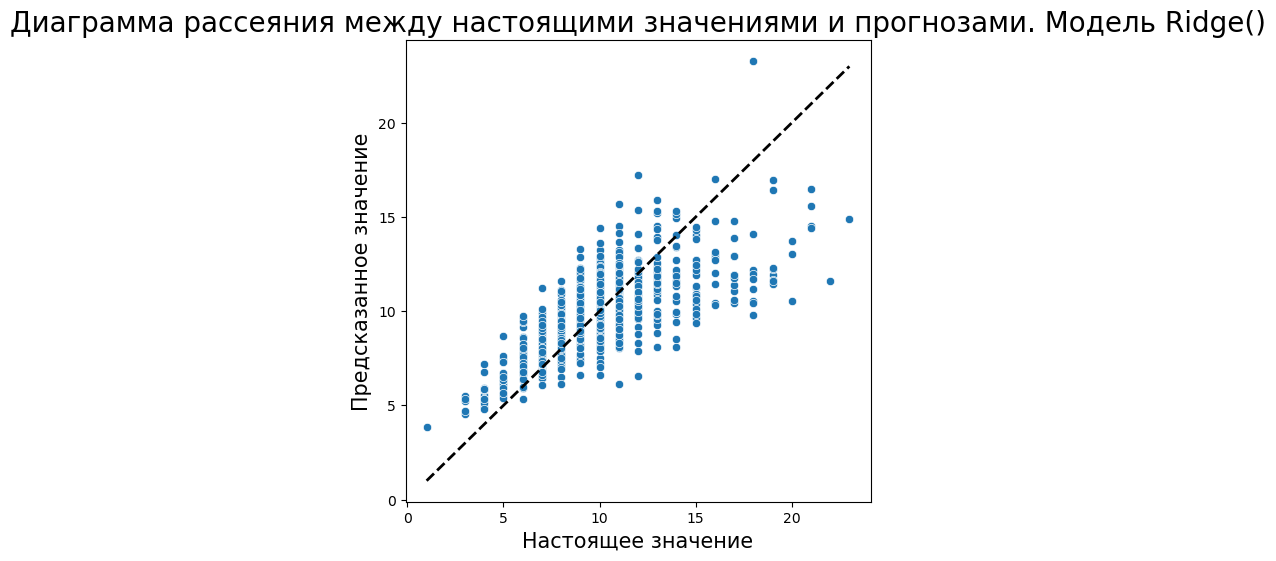

MAE_train: 1.669
MAE_test: 1.625
R2_test: 0.517
MAE (4 folds): 1.674
R2 (4 folds): 0.488


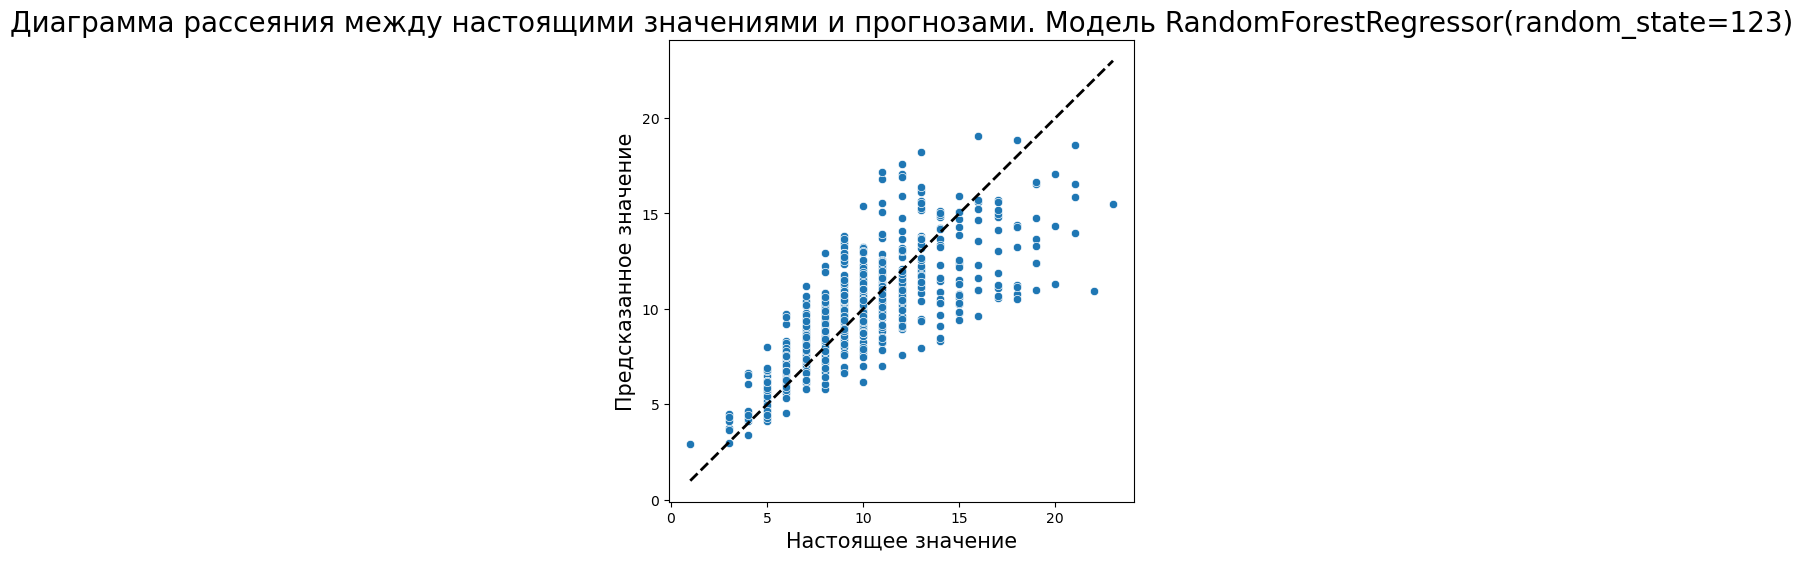

MAE_train: 0.588
MAE_test: 1.483
R2_test: 0.56
MAE (4 folds): 1.607
R2 (4 folds): 0.515


In [19]:
for model in additional_model:
    dict_model = lern_models(ml_model=model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
    model_scatterplot(y_test=y_test,
                      pred=dict_model['predictions'],
                      name_model=dict_model['model'],
                      train_mae_metr=dict_model['MAE_train'],
                      test_mae_metr=dict_model['MAE_test'],
                      test_r2_metr=dict_model['R2_test'],
                      mae_cv=dict_model['MAE_val'],
                      r2_cv=dict_model['R2_val']
                     )

**Комментарий по результатам**

1. Обучили три модели (`LinearRegression` и `Ridge`, а также `RandomForestRegressor`) на полном наборе данных.
2. Средняя абсолютная ошибка (mae) для всех моделей порядка `~1.6`, однако коэффициент детерминации у модели `RandomForestRegressor` выше, что означает, что данная модель сделает лучше предсказания на неизвестных данных.
3. Стоит заметить, что *MAE* модели `RandomForestRegressor` на train и test отличается ~1. Стоит провести проверку на переобучение.

#### Подбор гиперпарметров для каждой модели

In [20]:
X_train, X_test, y_train, y_test = preprocess_data(X, y, scaler = MinMaxScaler(), size_test = 0.2)

Создадим словарь, в котором будут лежать параметры для каждой интересующей нас модели.

In [21]:
params_model_dict = dict()
params_model_dict['BayesianRidge()'] = {'alpha_1' : [0.000001, 0.00001, 0.0001, 0.001],
                                        'alpha_2' : [0.000001, 0.00001, 0.0001, 0.001],
                                        'lambda_1' : [0.000001, 0.00001, 0.0001, 0.001],
                                        'lambda_2' : [0.000001, 0.00001, 0.0001, 0.001]
                                       }
params_model_dict['KNeighborsRegressor()'] = {'n_neighbors' : range(1,30),
                                        'weights' : ['uniform', 'distance'],
                                        'metric' : ['minkowski', 'euclidean', 'manhattan'],
                                        'p' : [1, 2]
                                       }
                       

In [22]:
def gs_best_model(ml_model, params_model_dict, X_train, y_train, X_test, y_test):
    '''
    Функция с помощью метода GridSearchCV подбирает лучшие гиперпараметры модели.
    Представляет отчет обученной модели.
    '''
    model = ml_model
    scoring = ['neg_mean_absolute_error', 'r2']
    params_model = params_model_dict[f'{(ml_model)}']
    
    gs = GridSearchCV(model,
                      params_model, 
                      scoring=scoring, 
                      refit='neg_mean_absolute_error', 
                      cv=5, 
                      n_jobs=-1,
                      verbose=2
                     )
    
    gs.fit(X_train, y_train)
    
    best_score_train = -1*gs.best_score_
    dict_best_params = gs.best_params_
    
    pred = gs.best_estimator_.predict(X_test)
    score_mae = mean_absolute_error(y_test, pred)
    score_r2 = r2_score(y_test, pred)

    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_test, y=pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  
    plt.xlabel('Настоящее значение', fontsize=15)
    plt.ylabel('Предсказанное значение', fontsize=15)
    plt.title(f'Диаграмма рассеяния между настоящими значениями и прогнозами. Модель {model}', fontsize=20)

    plt.show();
    print(dict_best_params)
    print(f'MAE_train: {best_score_train.round(3)}')
    print(f'MAE_test: {score_mae.round(3)}')
    print(f'R2_test: {score_r2.round(3)}')

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


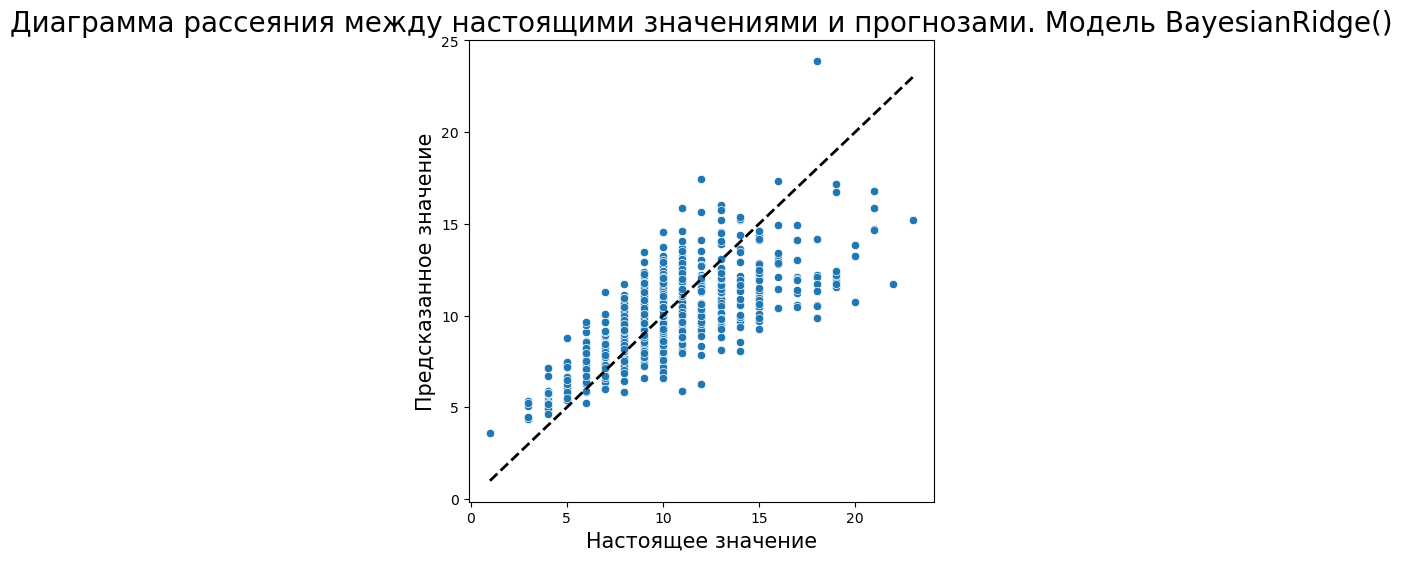

{'alpha_1': 0.001, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 0.001}
MAE_train: 1.669
MAE_test: 1.615
R2_test: 0.523
Fitting 5 folds for each of 348 candidates, totalling 1740 fits


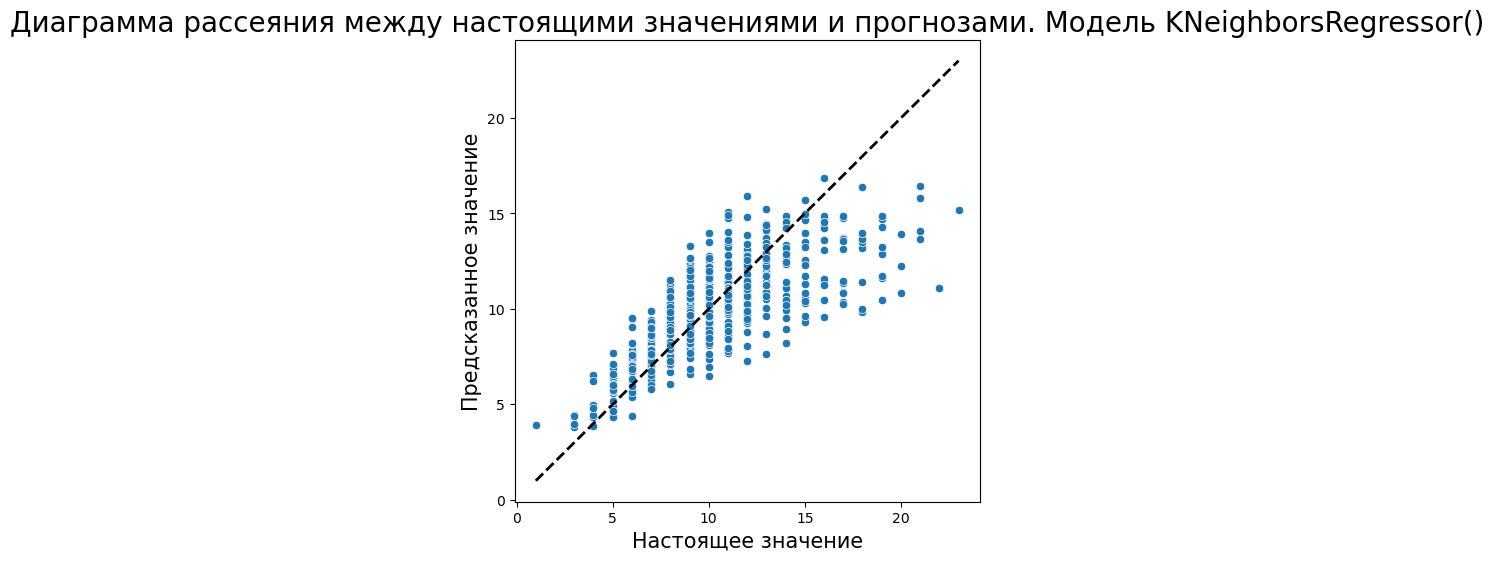

{'metric': 'minkowski', 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}
MAE_train: 1.541
MAE_test: 1.427
R2_test: 0.575


In [23]:
for model in basic_model:
    gs_best_model(ml_model=model,
                  params_model_dict=params_model_dict,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test
                 )

**Комментарий по результатам**

1. Обучили две модели на лучших подобранных гиперпараматрах(`BayesianRidge` и `KNeighborsRegressor`) на полном наборе данных.
2. Средня абсолютная ошибка (mae) для модели `KNeighborsRegressor` составляет `~1.43`, что улучшило наши показания `~0.2`.
3. Коэффициент детерминации у моделей вырос.

Подберем лучшие гиперпараметры на линейные модели LinearRegression и Ridge, а также на RandomForestRegressor.

LinearRegression() не имеет гиперпараметров.

In [24]:
params_model_dict['Ridge()'] = {'alpha' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
params_model_dict['RandomForestRegressor(random_state=123)'] = {'max_depth': range(2,15,3),
                                                                'criterion':['squared_error', 'absolute_error'],
                                                                'min_samples_leaf': range(2,10,2),
                                                               }

In [25]:
params_model_dict['RandomForestRegressor(random_state=123)']

{'max_depth': range(2, 15, 3),
 'criterion': ['squared_error', 'absolute_error'],
 'min_samples_leaf': range(2, 10, 2)}

In [26]:
additional_model_gs = [Ridge(), RandomForestRegressor(random_state=123)]

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


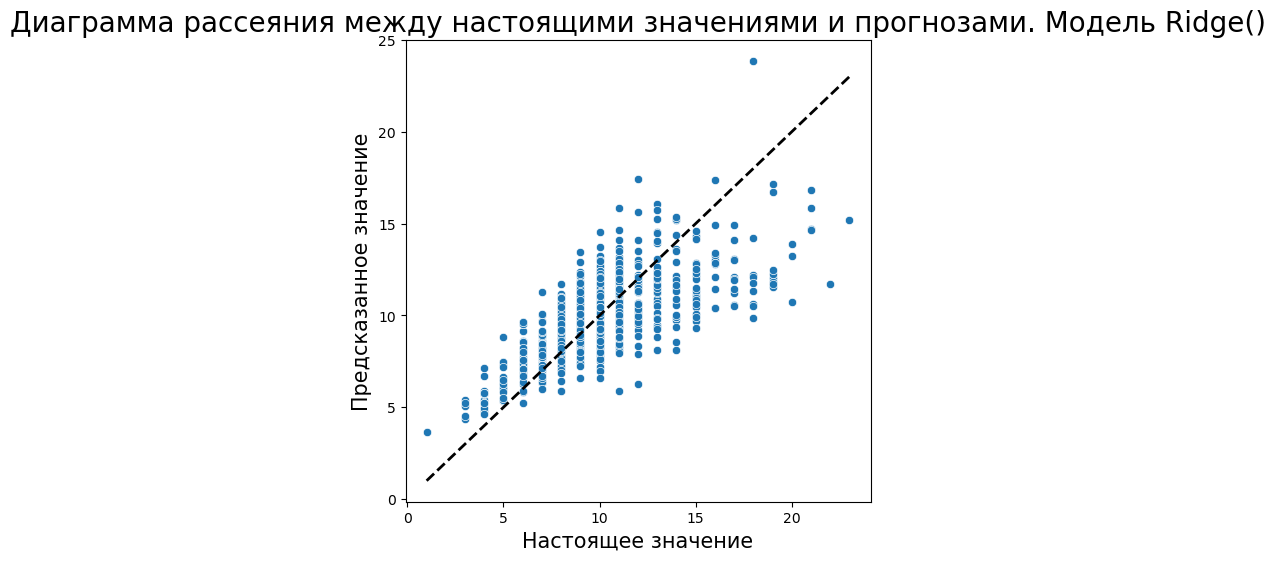

 50%|█████     | 1/2 [00:00<00:00,  1.32it/s]

{'alpha': 0.1}
MAE_train: 1.669
MAE_test: 1.615
R2_test: 0.523
Fitting 5 folds for each of 40 candidates, totalling 200 fits


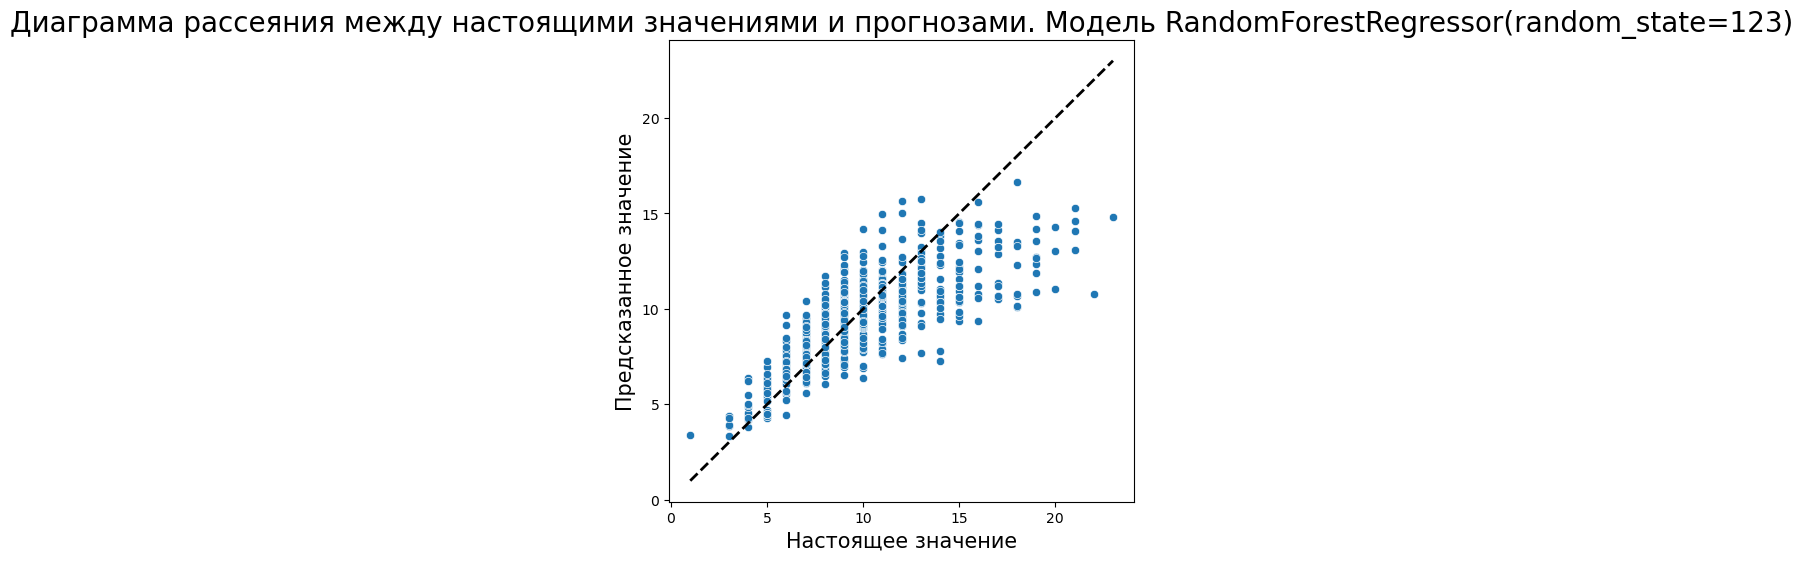

100%|██████████| 2/2 [09:32<00:00, 286.36s/it]

{'criterion': 'absolute_error', 'max_depth': 14, 'min_samples_leaf': 2}
MAE_train: 1.547
MAE_test: 1.415
R2_test: 0.571


In [27]:
for model in tqdm(additional_model_gs):
    gs_best_model(ml_model=model,
                  params_model_dict=params_model_dict,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test
                 )

**Комментарий по результатам**

1. Обучили две модели на лучших подобранных гиперпараматрах(`Ridge` и `RandomForestRegressor`) на полном наборе данных.
2. Средня абсолютная ошибка (mae) для модели `RandomForestRegressor` составляет `~1.41`, что уличшило наши показания `~0.2`.
3. Коэффициент детерминации у моделей вырос.

#### Результаты

В ходе обучения моделей удалось достичь максимального качества по метрике **MAE** равной `~1.4`. Данное качество показали модели `RandomForestRegressor` и `KNeighborsRegressor`. Однако коэффициент детерминации у второй модели лучше. Для дальнейшей работы возьмем модель, которая показала лучшее качество - `KNeighborsRegressor`.

#### Добавление категориальных признаков

**Обработка данных.**

С помощью OneHotEncoder закодируем признак `Sex`.

In [28]:
X_full = df.drop('Rings', axis=1)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.2, random_state=10)

In [29]:
categorical = list(X_full.select_dtypes('object').columns)
numeric_features = list(X_full.select_dtypes('number').columns)

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', MinMaxScaler(), numeric_features)
])

X_train_transformed = ct.fit_transform(X_train_full)
X_test_transformed = ct.transform(X_test_full)

In [30]:
new_features = list(ct.named_transformers_['ohe'].get_feature_names_out())
new_features.extend(numeric_features)

new_features

['Sex_F',
 'Sex_I',
 'Sex_M',
 'Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Shucked weight',
 'Viscera weight',
 'Shell weight']

In [31]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=new_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=new_features)

X_train_transformed.head()

,Sex_F,Sex_I,Sex_M,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,1.0,0.0,0.0,0.539007,0.482143,0.085202,0.174800,0.106698,0.178571,0.214765
1,0.0,1.0,0.0,0.368794,0.348214,0.071749,0.077374,0.074722,0.084184,0.072148
2,0.0,1.0,0.0,0.624113,0.633929,0.116592,0.275067,0.203299,0.263605,0.293065
3,0.0,0.0,1.0,0.780142,0.758929,0.125561,0.508784,0.473241,0.601190,0.371365
4,0.0,0.0,1.0,0.680851,0.678571,0.130045,0.425200,0.320767,0.409014,0.342282


#### Обучение модели

Fitting 5 folds for each of 348 candidates, totalling 1740 fits


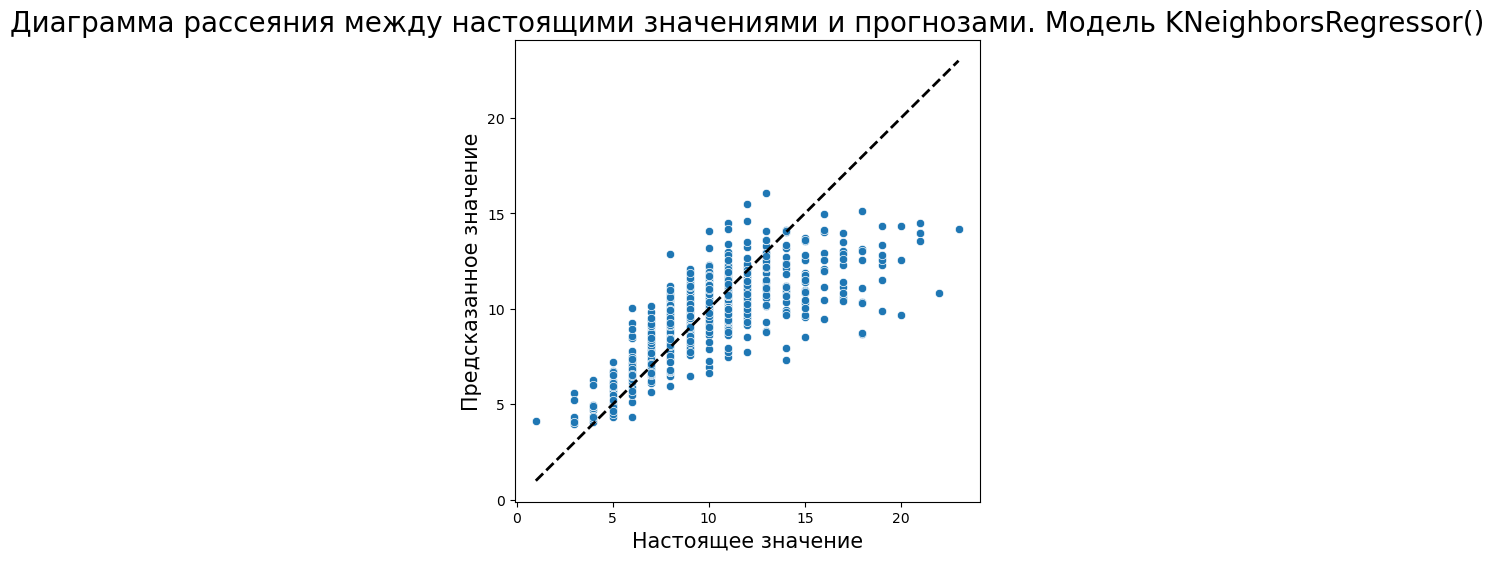

{'metric': 'minkowski', 'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
MAE_train: 1.576
MAE_test: 1.469
R2_test: 0.542


In [32]:
model = KNeighborsRegressor()
gs_best_model(ml_model=model,
              params_model_dict=params_model_dict,
              X_train=X_train_transformed,
              y_train=y_train_full,
              X_test=X_test_transformed,
              y_test=y_test_full
             )       

**Комментарий по результатам**

Метрики модели при добавлении категориальных переменных снизились незначительно.

Fitting 5 folds for each of 348 candidates, totalling 1740 fits


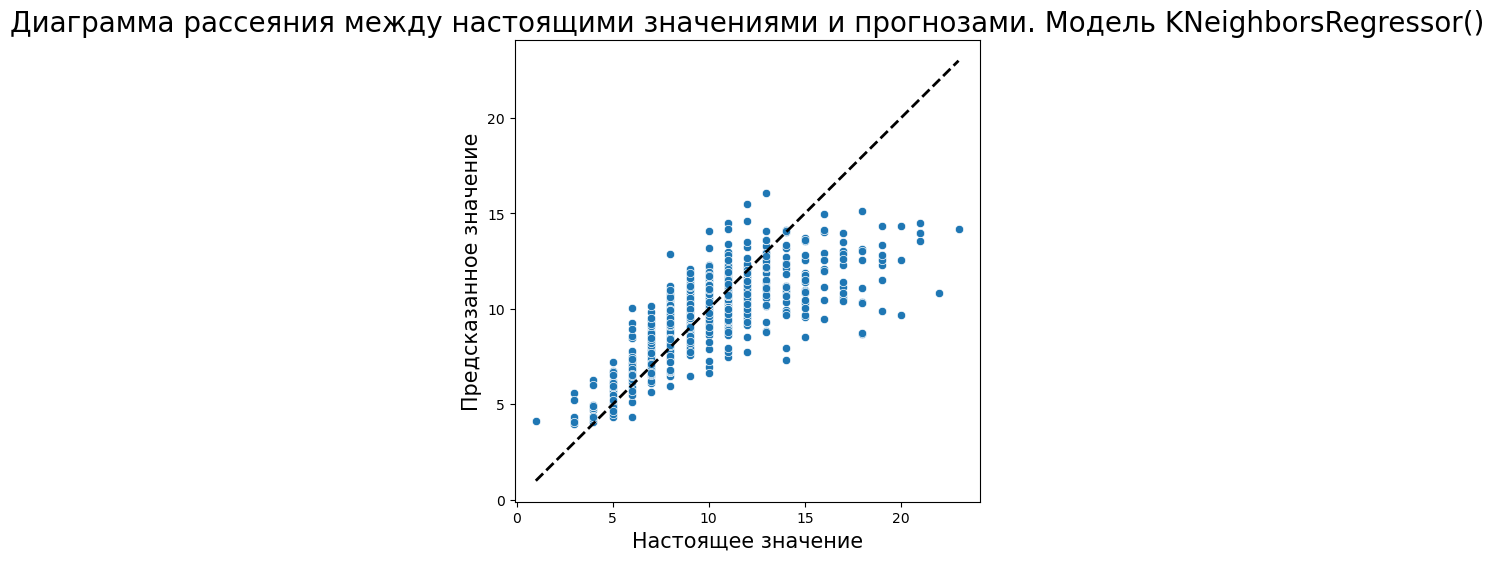

{'metric': 'minkowski', 'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
MAE_train: 1.576
MAE_test: 1.469
R2_test: 0.542


In [33]:
model = KNeighborsRegressor()
scoring = ['neg_mean_absolute_error', 'r2']
params_model = params_model_dict[f'{(model)}']
    
gs = GridSearchCV(model,
                  params_model, 
                  scoring=scoring, 
                  refit='neg_mean_absolute_error', 
                  cv=5, 
                  n_jobs=-1,
                  verbose=2
                  )
    
gs.fit(X_train_transformed, y_train_full)
    
best_score_train = -1*gs.best_score_
dict_best_params = gs.best_params_
    
pred = gs.best_estimator_.predict(X_test_transformed)
score_mae = mean_absolute_error(y_test_full, pred)
score_r2 = r2_score(y_test_full, pred)

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  
plt.xlabel('Настоящее значение', fontsize=15)
plt.ylabel('Предсказанное значение', fontsize=15)
plt.title(f'Диаграмма рассеяния между настоящими значениями и прогнозами. Модель {model}', fontsize=20)

plt.show();
print(dict_best_params)
print(f'MAE_train: {best_score_train.round(3)}')
print(f'MAE_test: {score_mae.round(3)}')
print(f'R2_test: {score_r2.round(3)}')

### Построение Explainer Dashboard

In [34]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

In [35]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [36]:
explainer = RegressionExplainer(gs.best_estimator_, X_test_transformed.iloc[:100], y_test_full.iloc[:100])

Generating self.shap_explainer = shap.KernelExplainer(model, X)...


In [37]:
db = ExplainerDashboard(explainer)

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [38]:
db.run()

Starting ExplainerDashboard on http://192.168.0.102:8050


ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8050): Max retries exceeded with url: /_alive_a4099b28-4a88-475c-b785-f3f8bd89cbca (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002C7B0A8CA90>: Failed to establish a new connection: [WinError 10049] Требуемый адрес для своего контекста неверен'))

**Выводы на основе модели в Explainer Dashboard**:
1. Наиболее значимые признаки в среднем по всему набору данных являются `Shucked weight` (вес мяса), `Shell weight` (вес оболочки) и `Length` (длина). Заметим, что и `SHAP values` первые два признака совпадают, что говорит о согласованности этих двух методов оценки важности признаков.
2. По метрике MAE = ~1,5 означает, что среднее абсолютное отклонение модели от реальных данных составляет 1.5.
3. Коэффициент детерминации равный 0.6 означает, что модель объясняет 60% изменчивости данных, что может быть рассмотрено как неплохой результат. Однако, это также означает, что 40% изменчивости данных остается не объясненной моделью, следовательно, можно сказать, что она не совершенная. Таким образом, можно сказать, что модель довольно хорошая, но требует улучшения для более точных прогнозов.

Проведем анализ 2-3 индивидуальных прогнозов.

**Index 24** 
- Предсказание: 9.693
- Истинное значение: 9 
- Для данного наблюдения MAE состовляет 0.693. Большое понижение к верному ответу давал признак `Shucked weight` и `Sex`, остальные уводили в разной мере наше предсказание вверх от истинного значения.

**Index 25** 
- Предсказание: 4.702
- Истинное значение: 4 
- Для данного наблюдения MAE состовляет 0.702. Все признаки с разной мерой подводили нас к верному результату.

#### Комментарий по улучшении модели

В данном ноутбуке не приводилось, но улучшить построение модели можно за счет:


1. Инженерия признаков: создание новых признаков на основе существующих данных может улучшить предсказательную способность модели. Добавить новые признаки, комбинировать существующие или использовать методы уменьшения размерности данных.
2. Использование других моделей: обучить другие модели машинного обучения, которые могут быть более подходящими для нашей задачи.